# Wealth Distribution Dynamics

Seho Jeong, Sogang University

**References**
- QuantEcon

In [18]:
import numpy as np
import pandas as pd
import quantecon as qe

import jax
import jax.numpy as jnp
import numba

import matplotlib.pyplot as plt

from time import time

In [12]:
# Customized colors
bg = '#F9F9F9'

In [2]:
def create_wealth_model(w_hat=1.0, # savings parameter
                        s_0=0.75,  # savings parameter
                        c_y=1.0,   # labor income parameter
                        μ_y=1.0,   # labor income parameter
                        σ_y=0.2,   # labor income parameter
                        c_r=0.05,  # rate of return parameter
                        μ_r=0.1,   # rate of return parameter
                        σ_r=0.5,   # rate of return parameter
                        a=0.5,     # aggregate shock parameter
                        b=0.0,     # aggregate shock parameter
                        σ_z=0.1):  # aggregate shock parameter
    """ 
    Create a wealth model with given parameters.

    Return a tuple model = (household_params, aggregate_params), 
    where `household_params` collects household information and `aggregate_params` collects information relevant to the aggregate shock process.
    """
    # Mean and variance of z process
    z_mean = b / (1 - a)
    z_var = σ_z ** 2 / (1 - a ** 2)
    exp_z_mean = np.exp(z_mean + z_var / 2)

    # Mean of R and y processes
    R_mean = c_r * exp_z_mean + np.exp(μ_r + σ_r ** 2 / 2)
    y_mean = c_y * exp_z_mean + np.exp(μ_y + σ_y ** 2 / 2)

    # Test stability condition ensuring wealth does not diverge to infinity.
    α = R_mean * s_0
    if α >= 1:
        raise ValueError('Stability condition failed.')

    # Pack values into tuples and return them.
    household_params = (w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean)
    aggregate_params = (a, b, σ_z, z_mean, z_var)
    model = household_params, aggregate_params
    return model

## Implementation with Numba

In [4]:
@numba.jit
def generate_aggregate_state_process(aggregate_params, length=100):
    a, b, σ_z, z_mean, z_var = aggregate_params
    z = np.empty(length + 1)
    # Initialize the process at z_mean.
    z[0] = z_mean
    for t in range(length):
        z[t + 1] = a * z[t] + b + σ_z * np.random.randn()
    return z

In [5]:
@numba.jit
def update_wealth(household_params, w, z):
    """ 
    Generate w_{t+1} given w_t and z_{t+1}.
    """
    # Unpack parameters.
    w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params

    # Update wealth.
    y = c_y * np.exp(z) + np.exp(μ_y + σ_y * np.random.randn())
    wp = y
    if w >= w_hat:
        R = c_r * np.exp(z) + np.exp(μ_r + σ_r * np.random.randn())
        wp += R * s_0 * w
    
    return wp

In [6]:
@numba.jit
def wealth_time_series(model, w_0, sim_length):
    """ 
    Generate a single time series of length `sim_length` for wealth given initial value w_0.
    The function generates its own aggregate shock sequence.
    """
    # Unpack parameters.
    household_params, aggregate_params = model
    a, b, σ_z, z_mean, z_var = aggregate_params

    # Initialize and update.
    z = generate_aggregate_state_process(aggregate_params, length=sim_length)
    w = np.empty(sim_length)
    w[0] = w_0
    for t in range(sim_length):
        w[t + 1] = update_wealth(household_params, w[t], z[t + 1])
    return w

In [7]:
model = create_wealth_model()
household_params, aggregate_params = model
w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
a, b, σ_z, z_mean, z_var = aggregate_params
ts_length = 200
w = wealth_time_series(model, y_mean, ts_length)

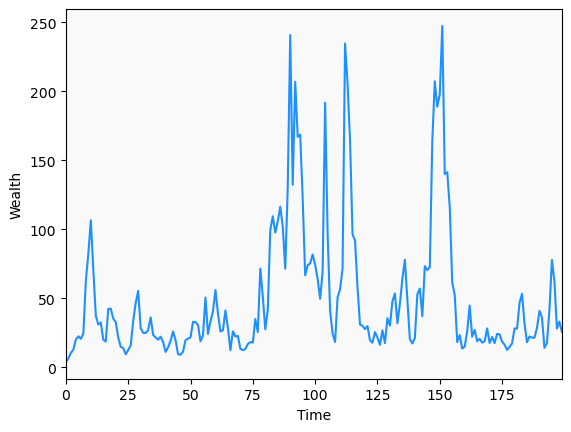

In [15]:
fig, ax = plt.subplots()

ax.plot(w, color='dodgerblue')

ax.set_facecolor(bg)
ax.set_xmargin(0)
ax.set_xlabel('Time')
ax.set_ylabel('Wealth')

plt.show()

In [26]:
# Parallelization
@numba.jit(parallel=True)
def update_cross_section(model, w_distribution, z_sequence, sim_length=200):
    """ 
    Shifts a cross-section of households forward in time.

    Takes
    - a current distribution of wealth values as w_distribution and 
    - an aggregate shock sequence z_sequence
    and updates each w_t in w_distribution to w_{t+j}, where j = len(z_sequence).

    Returns the new distribution
    """
    # Unpack parameters.
    household_params, aggregate_params = model

    num_households = len(w_distribution)
    new_distribution = np.empty_like(w_distribution)
    z = z_sequence

    # Update each household
    for i in numba.prange(num_households):
        w = w_distribution[i]
        for t in range(sim_length):
            w = update_wealth(household_params, w, z[t])
        new_distribution[i] = w
    
    return new_distribution

In [27]:
sim_length = 200
num_households = 10_000_000
ψ_0 = np.full(num_households, y_mean) # initial wealth distribution
z_sequence = generate_aggregate_state_process(aggregate_params, length=sim_length)

print('Generating cross-section using Numba')
start = time()
ψ_star = update_cross_section(model, ψ_0, z_sequence)
numba_with_compile = time() - start
print(f'Generated cross-section in {numba_with_compile} seconds.')

Generating cross-section using Numba
Generated cross-section in 9.602391004562378 seconds.


In [21]:
# Run it again to eliminate compile time.
print('Generating cross-section using Numba')
start = time()
ψ_star = update_cross_section(model, ψ_0, z_sequence)
numba_without_compile = time() - start
print(f'Generated cross-section in {numba_without_compile} seconds.')

Generating cross-section using Numba
Generated cross-section in 9.867138862609863 seconds.


## Implementation with JAX

In [22]:
def update_cross_section_jax(model, w_distribution, z_sequence, key):
    # Unpack, and simplify names.
    household_params, aggregate_params = model
    w_hat, s_0, c_y, μ_y, σ_y, c_r, μ_r, σ_r, y_mean = household_params
    w = w_distribution
    n_HHs = len(w)

    # Update wealth.
    for t, z in enumerate(z_sequence):
        U = jax.random.normal(key, (2, n_HHs))
        y = c_y * jnp.exp(z) + jnp.exp(μ_y + σ_y * U[0, :])
        R = c_r * jnp.exp(z) + jnp.exp(μ_r + σ_r * U[1, :])
        w = y + jnp.where(w < w_hat, 0.0, R * s_0 * w)
        key, subkey = jax.random.split(key)

    return w

In [23]:
sim_length = 200
num_households = 10_000_000
ψ_0 = jnp.full(num_households, y_mean) # initial distribution
z_sequence = generate_aggregate_state_process(aggregate_params, length=sim_length)
z_sequence = jnp.array(z_sequence)

In [24]:
print('Generating cross-section using JAX')
key = jax.random.PRNGKey(1234)
start = time()
ψ_star = update_cross_section_jax(model, ψ_0, z_sequence, key).block_until_ready()
jax_with_compile = time() - start
print(f'Generated cross-section in {jax_with_compile} seconds.')

Generating cross-section using JAX
Generated cross-section in 9.605401277542114 seconds.


In [25]:
print('Repeating without compile time.')
key = jax.random.PRNGKey(1234)
start = time()
ψ_star = update_cross_section_jax(model, ψ_0, z_sequence, key).block_until_ready()
jax_without_compile = time() - start
print(f'Generated cross-section in {jax_without_compile} seconds.')

Repeating without compile time.
Generated cross-section in 9.379496097564697 seconds.
